# メルスペクトログラムから鳥の鳴き声を分類するディープラーニングモデル

このノートブックでは、メルスペクトログラムを入力として鳥の鳴き声を分類するEfficientNet B0モデルを構築します。

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss

In [2]:
# GPUの設定
print("TensorFlowバージョン:", tf.__version__)
print("GPUが利用可能か:", len(tf.config.list_physical_devices('GPU'))>0)
print("利用可能なデバイス:")
for device in tf.config.list_physical_devices():
    print(device)

TensorFlowバージョン: 2.17.1
GPUが利用可能か: True
利用可能なデバイス:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## データの読み込み

In [3]:
# メルスペクトログラムデータの読み込み
mel_data_path = "/home/working/exp1/output/meldata.npy"
mel_data = np.load(mel_data_path, allow_pickle=True).item()
print(f"メルスペクトログラムデータポイント数: {len(mel_data)}")

メルスペクトログラムデータポイント数: 5000


In [4]:
# トレーニングデータ情報の読み込み
df_train = pd.read_csv('/home/data/train.csv').head(5000)

# メルスペクトログラムが作成されたデータのみを抽出
available_indices = list(mel_data.keys())
df_filtered = df_train.loc[available_indices].reset_index(drop=True)
print(f"利用可能なトレーニングデータ数: {len(df_filtered)}")

利用可能なトレーニングデータ数: 5000


In [5]:
# クラスのエンコーディング
label_encoder = LabelEncoder()
df_filtered['encoded_label'] = label_encoder.fit_transform(df_filtered['primary_label'])
num_classes = len(label_encoder.classes_)
print(f"分類するクラス数: {num_classes}")

分類するクラス数: 81


## データの前処理

メルスペクトログラムデータを画像としてモデルに入力するための前処理を行います。

In [6]:
def prepare_mel_for_model(mel_spec, target_shape=(224, 224)):
    """
    メルスペクトログラムをEfficientNetの入力用に前処理する
    """
    # 正規化 (-80dB〜0dBを0〜1に変換)
    mel_spec = (mel_spec + 80) / 80
    mel_spec = np.clip(mel_spec, 0, 1)
    
    # 現在のサイズを取得
    height, width = mel_spec.shape
    
    # ターゲットサイズに調整
    if width < target_shape[1]:
        # 短い場合はパディング
        pad_width = target_shape[1] - width
        mel_spec = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant')
    elif width > target_shape[1]:
        # 長い場合は中央部分を切り取り
        start = (width - target_shape[1]) // 2
        mel_spec = mel_spec[:, start:start+target_shape[1]]
    
    # リサイズ (高さ方向)
    mel_spec = tf.image.resize(mel_spec[np.newaxis, :, :, np.newaxis], 
                              (target_shape[0], target_shape[1])).numpy()
    
    # RGBチャンネルに変換 (グレースケールを3チャンネルに複製)
    mel_spec = np.concatenate([mel_spec] * 3, axis=-1)[0]
    
    return mel_spec

In [7]:
# データセットの作成
X = []
y = []

for idx, row in tqdm(df_filtered.iterrows(), total=len(df_filtered), desc="データ前処理中"):
    orig_idx = row.name
    if orig_idx in mel_data:
        mel_spec = mel_data[orig_idx]
        processed_mel = prepare_mel_for_model(mel_spec)
        X.append(processed_mel)
        y.append(row['encoded_label'])

X = np.array(X)
y = np.array(y)

print(f"入力データの形状: {X.shape}")
print(f"ラベルデータの形状: {y.shape}")

データ前処理中:   0%|          | 0/5000 [00:00<?, ?it/s]

入力データの形状: (5000, 224, 224, 3)
ラベルデータの形状: (5000,)


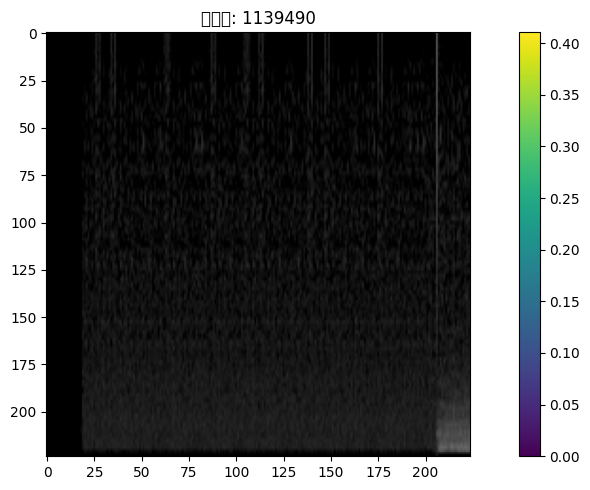

In [8]:
# サンプルデータの可視化
plt.figure(figsize=(10, 5))
plt.imshow(X[0])
plt.title(f'クラス: {label_encoder.inverse_transform([y[0]])[0]}')
plt.colorbar()
plt.tight_layout()
plt.show()

## トレーニングとテストデータの分割

層化抽出サンプリングを使用して、各クラスの比率が均等になるようにデータを分割します。

In [30]:
X.shape

(5000, 224, 224, 3)

In [31]:
y

array([ 0,  0,  1, ..., 80, 80, 80])

In [9]:
# 訓練データとテストデータに分割
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"学習データ: {X_train.shape}")
print(f"検証データ: {X_val.shape}")

学習データ: (4000, 224, 224, 3)
検証データ: (1000, 224, 224, 3)


## モデルの構築

EfficientNet B0をベースにした転移学習モデルを構築します。

In [11]:
def build_model(input_shape=(224, 224, 3), num_classes=None):
    """
    EfficientNet B0をベースにしたモデルを構築する
    """
    # 事前学習済みのEfficientNetB0をベースモデルとして読み込み
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    
    # ベースモデルの重みを凍結
    base_model.trainable = False
    
    # 新しいモデルを構築
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [12]:
# モデルの構築
model = build_model(num_classes=num_classes)

# モデルのコンパイル
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデルの概要
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 26s 2us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 26s 2us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 81)                  │          20,817 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,398,324 (16.78 MB)

 Trainable params: 348,753 (1.33 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## モデルのトレーニング

In [14]:
# コールバックの設定
checkpoint_path = "/home/working/exp1/output/best_model.keras"
checkpoint_callback = callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

In [15]:
# データ拡張の設定
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    zoom_range=0.1,
    horizontal_flip=True
)

In [16]:
# モデルのトレーニング
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_callback, early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/30
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.0986 - loss: 3.7750
Epoch 1: val_loss improved from inf to 3.33712, saving model to /home/working/exp1/output/best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.0986 - loss: 3.7715 - val_accuracy: 0.1220 - val_loss: 3.3371 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.1057 - loss: 3.3884
Epoch 2: val_loss improved from 3.33712 to 3.33456, saving model to /home/working/exp1/output/best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 198ms/step - accuracy: 0.1057 - loss: 3.3885 - val_accuracy: 0.1220 - val_loss: 3.3346 - learning_rate: 0.0010
Epoch 3/30
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.1078 - loss: 3.3677
Epoch 3: val_loss improved from 3.33456 to 3.33313, saving model to /home/working/exp1/output/best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 198ms/step - accuracy: 0.1078 - loss: 3.3681 - val_accuracy: 0.1220 - val_loss: 3.3331

## モデルの評価

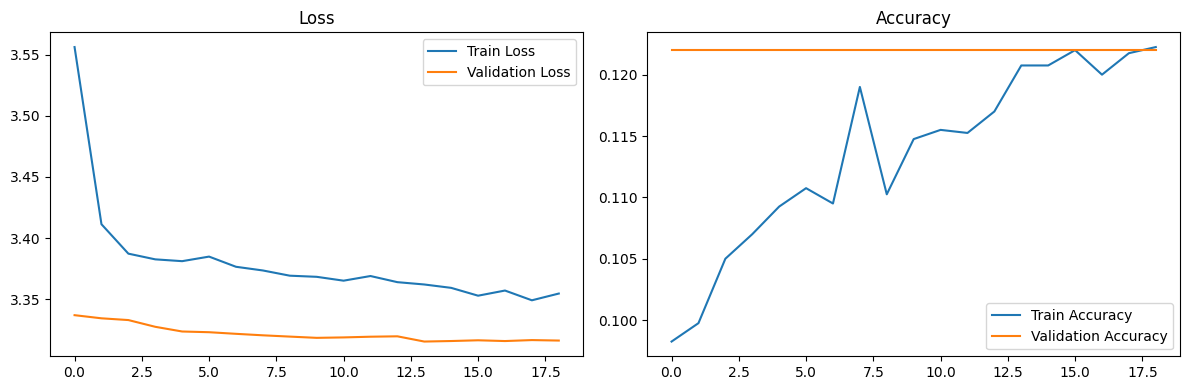

In [17]:
# 学習履歴の可視化
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# モデルの評価（最適化指標: LogLoss）
y_pred_prob = model.predict(X_val)
logloss = log_loss(y_val, y_pred_prob)
print(f"LogLoss: {logloss:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step


ValueError: y_true and y_pred contain different number of classes 66, 81. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [ 1  2  3  4  5  6  7  8  9 12 13 14 15 16 17 18 19 21 22 25 28 29 30 31
 32 34 35 36 37 38 40 41 42 43 44 45 46 47 51 53 54 55 56 58 59 60 61 62
 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]

In [25]:
# AUCの計算（one-vs-restアプローチ）
y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

# 検証データに実際に存在するクラスを特定
unique_classes = np.unique(y_val)
print(f"検証データに存在するクラス数: {len(unique_classes)}")

# クラスごとのAUCを計算（実際に存在するクラスのみ）
auc_scores = []
for i in unique_classes:
    # そのクラスのサンプルが存在する場合のみ
    auc = roc_auc_score(y_val_onehot[:, i], y_pred_prob[:, i])
    auc_scores.append(auc)
    print(f"クラス {label_encoder.inverse_transform([i])[0]} のAUC: {auc:.4f}")

# 平均AUC
mean_auc = np.mean(auc_scores)
print(f"\n平均 AUC: {mean_auc:.4f}")

検証データに存在するクラス数: 66
クラス 1192948 のAUC: 0.7317
クラス 1194042 のAUC: 0.4104
クラス 126247 のAUC: 0.0080
クラス 1346504 のAUC: 0.4024
クラス 134933 のAUC: 0.2593
クラス 135045 のAUC: 0.7570
クラス 1462711 のAUC: 0.8549
クラス 1462737 のAUC: 0.7119
クラス 1564122 のAUC: 0.0130
クラス 21211 のAUC: 0.5486
クラス 22333 のAUC: 0.2749
クラス 22973 のAUC: 0.2704
クラス 22976 のAUC: 0.3239
クラス 24272 のAUC: 0.9289
クラス 24292 のAUC: 0.8098
クラス 24322 のAUC: 0.5082
クラス 41663 のAUC: 0.5060
クラス 41970 のAUC: 0.8529
クラス 42007 のAUC: 0.3898
クラス 46010 のAUC: 0.6416
クラス 476538 のAUC: 0.9079
クラス 48124 のAUC: 0.3931
クラス 50186 のAUC: 0.7116
クラス 517119 のAUC: 0.6055
クラス 523060 のAUC: 0.2252
クラス 52884 のAUC: 0.5849
クラス 548639 のAUC: 0.4384
クラス 555086 のAUC: 0.3580
クラス 555142 のAUC: 0.0521
クラス 566513 のAUC: 0.4062
クラス 65336 のAUC: 0.1281
クラス 65344 のAUC: 0.5028
クラス 65349 のAUC: 0.6680
クラス 65373 のAUC: 0.4981
クラス 65419 のAUC: 0.9369
クラス 65448 のAUC: 0.2611
クラス 65547 のAUC: 0.7049
クラス 65962 のAUC: 0.5916
クラス 66893 のAUC: 0.0300
クラス 67252 のAUC: 0.9325
クラス 714022 のAUC: 0.3854
クラス 715170 のAUC

## ファインチューニング

事前学習済みモデルの一部の層を解凍してファインチューニングを行います。

In [21]:
# 最良のモデルを読み込む
model.load_weights(checkpoint_path)

# EfficientNetの最後の数層を解凍
base_model = model.layers[0]
for layer in base_model.layers[-20:]:  # 最後の20層を微調整
    layer.trainable = True

# より小さい学習率で再コンパイル
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
# ファインチューニングの実行
finetune_history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=16),
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_callback, early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/10
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.1037 - loss: 3.4524
Epoch 1: val_loss did not improve from 3.31558
250/250 ━━━━━━━━━━━━━━━━━━━━ 59s 137ms/step - accuracy: 0.1037 - loss: 3.4520 - val_accuracy: 0.1220 - val_loss: 3.5274 - learning_rate: 1.0000e-04
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.1207 - loss: 3.3847
Epoch 2: val_loss did not improve from 3.31558
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 106ms/step - accuracy: 0.1206 - loss: 3.3848 - val_accuracy: 0.1220 - val_loss: 3.3204 - learning_rate: 1.0000e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.1110 - loss: 3.3954
Epoch 3: val_loss did not improve from 3.31558
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.1110 - loss: 3.3953 - val_accuracy: 0.1220 - val_loss: 3.3176 - learning_rate: 1.0000e-04
Epoch 4/10
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.1093 - loss: 3.3991
Epoch 4: val_loss did not improve from 3.31558
250/250 ━━━━━━━━

In [36]:
y_pred_prob_ft.idx()

AttributeError: 'numpy.ndarray' object has no attribute 'idx'

In [34]:
y_val

array([72, 61, 68, 73, 34, 61, 72, 61, 30, 61, 12, 70, 71, 76,  2, 61, 79,
       64, 19, 61, 72, 66, 68, 72, 72, 38, 14, 15, 36, 72, 60, 66, 68, 61,
       72, 73, 13, 80, 68, 72, 61, 72, 67, 66, 72, 60, 80, 19, 63, 72, 72,
       60, 30, 68, 29, 15,  5, 72, 19, 76, 76, 41, 68, 70, 70, 70, 71, 72,
       68, 66, 71, 66, 68, 73, 61, 66, 19, 70, 22, 70, 68, 61, 61, 72, 72,
       66, 78, 61, 64, 61, 68, 80, 68, 61, 78, 79, 70, 64, 19, 80, 34, 78,
       53, 80, 63, 71, 66, 66, 71, 45, 72, 80, 66, 63, 76, 12, 74, 73, 67,
       45, 67, 60, 30, 80, 41, 68, 53, 72, 63, 66, 76, 79, 66, 80, 78, 54,
       80, 74, 43, 62, 61, 69, 66, 61, 19, 68, 61, 67, 67, 72, 68, 68, 80,
       65, 80, 31, 69,  4, 53, 74, 64, 66, 75, 68, 61, 68, 72, 71, 43, 66,
       80,  3, 78, 72, 12, 61, 71, 61, 61, 66, 80, 66, 69, 66, 61, 63, 12,
       66, 73, 72, 76, 61, 69, 80, 14, 66, 61, 55, 74, 80, 64, 63, 60, 71,
       68, 75, 66, 76, 67, 67, 80, 75, 71, 31, 68, 18, 72, 72, 45, 80, 79,
       63, 68, 68, 66, 77

In [27]:
# ファインチューニング後のモデル評価
y_pred_prob_ft = model.predict(X_val)
logloss_ft = log_loss(y_val, y_pred_prob_ft)
print(f"ファインチューニング後のLogLoss: {logloss_ft:.4f}")

# 検証データに実際に存在するクラスを特定
unique_classes = np.unique(y_val)

# クラスごとのAUCを計算（実際に存在するクラスのみ）
auc_scores_ft = []
for i in unique_classes:
    auc = roc_auc_score(y_val_onehot[:, i], y_pred_prob_ft[:, i])
    auc_scores_ft.append(auc)
    
# 平均AUC
mean_auc_ft = np.mean(auc_scores_ft)
print(f"ファインチューニング後の平均 AUC: {mean_auc_ft:.4f}")

# クラスごとの改善度を表示（上位10クラス）
improvements = []
for idx, cls in enumerate(unique_classes):
    original_auc = auc_scores[idx]
    new_auc = auc_scores_ft[idx]
    improvement = new_auc - original_auc
    improvements.append((label_encoder.inverse_transform([cls])[0], improvement))

# 改善度でソート
improvements.sort(key=lambda x: x[1], reverse=True)
print("\nファインチューニングによる上位10クラスのAUC改善:")
for cls, imp in improvements[:10]:
    print(f"クラス {cls}: {imp:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


ValueError: y_true and y_pred contain different number of classes 66, 81. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [ 1  2  3  4  5  6  7  8  9 12 13 14 15 16 17 18 19 21 22 25 28 29 30 31
 32 34 35 36 37 38 40 41 42 43 44 45 46 47 51 53 54 55 56 58 59 60 61 62
 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]

## 最終モデルの保存

In [ ]:
# 最終モデルの保存
model.save('/home/working/exp1/output/bird_classifier_model')
print("モデルを保存しました: /home/working/exp1/output/bird_classifier_model")

# ラベルエンコーダの保存
import pickle
with open('/home/working/exp1/output/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("ラベルエンコーダを保存しました: /home/working/exp1/output/label_encoder.pkl")